## Install protobuf

In [ ]:
# ============================================================================
# SEL 1: INSTALL
# ============================================================================
!pip install protobuf==3.20.3

Memasang versi protobuf spesifik (3.20.3) agar TensorFlow tidak error saat dijalankan.

## Import Library

In [ ]:
# ============================================================================
# SEL 2: SEMUA IMPORT LIBRARY
# ============================================================================
import tensorflow as tf
import os
import shutil
import time
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from PIL import Image

from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.preprocessing import image_dataset_from_directory, image
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

print("Semua library berhasil di-import.")

Semua library berhasil di-import.


Memanggil semua library yang akan digunakan:

- tensorflow (sebagai tf): library untuk machine learning dan membangun model CNN.

- os, shutil, time: Untuk urusan manajemen file, folder (copy, hapus), dan menghitung waktu.

- matplotlib.pyplot (plt), seaborn (sns): Untuk membuat grafik dan visualisasi data (seperti plot akurasi dan confusion matrix).

- numpy (np): Untuk mengurus angka dan array (matriks) gambar.

- PIL (Image): Untuk membuka dan memverifikasi file gambar.

- Tensorflow.keras: menggunakan komponen spesifik untuk membangun model (layers, models), memuat data (image_dataset_from_directory), dan callbacks (training seperti EarlyStopping).

- Sklearn.metrics: Untuk mencetak laporan performa model (classification_report, confusion_matrix).

## GPU Check & Configurasi

In [ ]:
# ============================================================================
# TAHAP 0: GPU CHECK
# ============================================================================
print("="*80)
print("TAHAP 0: GPU CHECK")
print("="*80)
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✓ GPU ENABLED - {len(gpus)} GPU(s) found. Memory growth set.")
    except RuntimeError as e:
        print(f"  Error setting memory growth: {e}")
else:
    print("⚠ TIDAK ADA GPU - training akan lambat")

# ============================================================================
# TAHAP 1: CONFIG (DENGAN KELAS BARU & NAMA MODEL BARU)
# ============================================================================
print("\n" + "="*80)
print("TAHAP 1: KONFIGURASI (v5 - Kelas Baru)")
print("="*80)

# Path Read-Only tempat dataset asli berada
BASE_DIR = '/kaggle/input/mineral-photos/data/data'
# Path Read-Write (TEMP_DIR) tempat kita akan bekerja
TEMP_DIR = '/kaggle/working/mineral_selected_v5' # v5 untuk data baru

# [PERUBAHAN] Ini adalah 5 kelas baru yang secara visual sangat berbeda
LABELS_TO_USE = ['azurite', 'calcite', 'malachite', 'hematite', 'copper']

IMG_SIZE = (224, 224) #
BATCH_SIZE = 32
MAX_EPOCHS = 150 #

# [PERUBAHAN] Ganti nama file model agar tidak menimpa yang lama
MODEL_SAVE_PATH = '/kaggle/working/best_mineral_model_v5.keras'

print(f"BASE_DIR (Sumber): {BASE_DIR}")
print(f"TEMP_DIR (Kerja): {TEMP_DIR}")
print(f"LABELS_TO_USE: {LABELS_TO_USE}")
print(f"IMG_SIZE: {IMG_SIZE}")
print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"MAX_EPOCHS: {MAX_EPOCHS}")
print(f"MODEL_SAVE_PATH: {MODEL_SAVE_PATH}")

TAHAP 0: GPU CHECK
✓ GPU ENABLED - 2 GPU(s) found. Memory growth set.

TAHAP 1: KONFIGURASI (v5 - Kelas Baru)
BASE_DIR (Sumber): /kaggle/input/mineral-photos/data/data
TEMP_DIR (Kerja): /kaggle/working/mineral_selected_v5
LABELS_TO_USE: ['azurite', 'calcite', 'malachite', 'hematite', 'copper']
IMG_SIZE: (224, 224)
BATCH_SIZE: 32
MAX_EPOCHS: 150
MODEL_SAVE_PATH: /kaggle/working/best_mineral_model_v5.keras


Tahap 0: Memastikan GPU aktif agar proses training cepat.

Tahap 1: Mengatur "panel kontrol" proyek. Kita putuskan untuk fokus melatih 5 kelas mineral saja, dengan ukuran gambar 224x224, dan model akan disimpan sebagai _v5.keras.

In [ ]:
# ============================================================================
# TAHAP 2: COPY DATA
# ============================================================================
print("\n" + "="*80)
print("TAHAP 2: COPY DATA (Versi Cepat: copytree)")
print("="*80)

if os.path.exists(TEMP_DIR):
    print(f"  Menghapus TEMP_DIR lama: {TEMP_DIR}")
    shutil.rmtree(TEMP_DIR)

total_files_copied = 0
copy_start = time.time()

for class_name in LABELS_TO_USE:
    src = os.path.join(BASE_DIR, class_name)
    dst = os.path.join(TEMP_DIR, class_name)
    if not os.path.exists(src):
        print(f"  [PERINGATAN] {class_name}: Folder tidak ditemukan di {BASE_DIR}")
        continue
    try:
        shutil.copytree(src, dst, ignore=shutil.ignore_patterns('*.db', '*.txt', '.*'))
        count = len([f for f in os.listdir(dst) if f.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp'))])
        total_files_copied += count
        print(f"  ✓ {class_name}: {count} file disalin")
    except Exception as e:
        print(f"    Gagal menyalin folder {class_name}: {e}")
copy_end = time.time()
print(f"\n✓ Total file disalin: {total_files_copied}")
print(f"  Waktu penyalinan: {copy_end - copy_start:.2f} detik")


TAHAP 2: COPY DATA (Versi Cepat: copytree)
  ✓ azurite: 1250 file disalin
  ✓ calcite: 6574 file disalin
  ✓ malachite: 1607 file disalin
  ✓ hematite: 1284 file disalin
  ✓ copper: 1429 file disalin

✓ Total file disalin: 12144
  Waktu penyalinan: 183.29 detik


Tahap 2: Menyalin 12.144 file gambar dari 5 kelas yang kita pilih ke direktori kerja.

In [ ]:
# ============================================================================
# TAHAP 3: CLEANING DATA (di TEMP_DIR)
# ============================================================================
print("\n" + "="*80)
print(f"TAHAP 3: CLEANING DATA (di {TEMP_DIR})")
print("="*80)

corrupted_files_found = 0
for class_folder in LABELS_TO_USE:
    class_path = os.path.join(TEMP_DIR, class_folder)
    if not os.path.isdir(class_path): continue

    print(f"\n  Checking class: {class_folder}")
    class_corrupt = 0
    for img_file in os.listdir(class_path):
        img_path = os.path.join(class_path, img_file)
        if not img_file.lower().endswith(('.jpg', '.jpeg', '.png', '.bmp')):
            continue
        try:
            if os.path.getsize(img_path) == 0: raise Exception("Empty file")
            img = Image.open(img_path)
            img.verify()
            img = Image.open(img_path)
            img.load()
        except Exception as e:
            print(f"    [CORRUPT] {img_file} -> {str(e)[:50]}")
            corrupted_files_found += 1
            class_corrupt += 1
            try:
                os.remove(img_path)
                print(f"    [DELETED]")
            except: pass
    print(f"    Result: {class_corrupt} CORRUPT file(s) deleted.")

print(f"\nCleaning Summary: Total {corrupted_files_found} file(s) corrupt deleted.")


TAHAP 3: CLEANING DATA (di /kaggle/working/mineral_selected_v5)

  Checking class: azurite
    Result: 0 CORRUPT file(s) deleted.

  Checking class: calcite
    Result: 0 CORRUPT file(s) deleted.

  Checking class: malachite
    Result: 0 CORRUPT file(s) deleted.

  Checking class: hematite
    Result: 0 CORRUPT file(s) deleted.

  Checking class: copper
    Result: 0 CORRUPT file(s) deleted.

Cleaning Summary: Total 0 file(s) corrupt deleted.


Tahap 3: Memeriksa semua gambar itu. Jika ada yang rusak/korup (file 0 byte, dsb.), file itu akan dihapus agar tidak mengganggu training. (Di sini 0 file korup).

In [ ]:
# ============================================================================
# TAHAP 4: MEMUAT DATASET (dari TEMP_DIR)
# ============================================================================
print("\n" + "="*80)
print("TAHAP 4: MEMUAT DATASET (dari TEMP_DIR)")
print("="*80)

print(f"\nMemuat dataset dari: {TEMP_DIR}")
dataset = image_dataset_from_directory(
    TEMP_DIR,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    label_mode='int',
    seed=42,
    shuffle=True
)
class_names = dataset.class_names
num_classes = len(class_names)
print(f"\nDataset berhasil dimuat! Kelas: {class_names}")


TAHAP 4: MEMUAT DATASET (dari TEMP_DIR)

Memuat dataset dari: /kaggle/working/mineral_selected_v5
Found 12144 files belonging to 5 classes.


I0000 00:00:1762683721.326107      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1762683721.326923      48 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5



Dataset berhasil dimuat! Kelas: ['azurite', 'calcite', 'copper', 'hematite', 'malachite']


Tahap 4: Menggunakan fungsi Keras untuk memuat 12.144 gambar tadi. Keras otomatis tahu ada 5 kelas dari nama foldernya.

In [ ]:
# ============================================================================
# TAHAP 5: SPLITTING DATASET
# ============================================================================
print("\n" + "="*80)
print("TAHAP 5: SPLITTING DATASET")
print("="*80)

total_batches = len(dataset)
train_ratio = 0.7
val_ratio = 0.15
train_size = int(total_batches * train_ratio)
val_size = int(total_batches * val_ratio)
test_size = total_batches - train_size - val_size
if test_size <= 0: test_size = 1
if val_size <= 0: val_size = 1

print(f"Info Pembagian (Batches): Train={train_size}, Val={val_size}, Test={test_size}")
train_dataset = dataset.take(train_size)
val_dataset = dataset.skip(train_size).take(val_size)
test_dataset = dataset.skip(train_size + val_size).take(test_size)
print("Status: Dataset berhasil dibagi.")


TAHAP 5: SPLITTING DATASET
Info Pembagian (Batches): Train=266, Val=57, Test=57
Status: Dataset berhasil dibagi.


Tahap 5: Membagi data: 70% untuk Latihan (train), 15% untuk Validasi/Koreksi (val), dan 15% untuk Ujian Akhir (test).

In [ ]:
# ============================================================================
# TAHAP 6: PREPROCESSING
# ============================================================================
print("\n" + "="*80)
print("TAHAP 6: PREPROCESSING (Metode Asli .map)")
print("="*80)

def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, 0.2)
    image = tf.image.random_saturation(image, 0.8, 1.2)
    image = tf.image.random_contrast(image, 0.8, 1.2)
    return image, label

def normalize_image(image, label):
    image = tf.cast(image, tf.float32)
    image = image / 255.0
    return image, label

AUTOTUNE = tf.data.AUTOTUNE

train_dataset = (
    train_dataset
    .map(augment_image, num_parallel_calls=AUTOTUNE)
    .map(normalize_image, num_parallel_calls=AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)
val_dataset = (
    val_dataset
    .map(normalize_image, num_parallel_calls=AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)
test_dataset = (
    test_dataset
    .map(normalize_image, num_parallel_calls=AUTOTUNE)
    .prefetch(buffer_size=AUTOTUNE)
)
print("Status: Augmentasi .map() & normalisasi diterapkan.")


TAHAP 6: PREPROCESSING (Metode Asli .map)
Status: Augmentasi .map() & normalisasi diterapkan.


Tahap 6: Semua gambar dnormalisasi (skala 0-255 jadi 0-1). Khusus data train, kita lakukan augmentasi (diacak acak: dibalik, dicerahkan) agar model tidak gampang hafal (anti-overfitting).

In [ ]:
# ============================================================================
# TAHAP 7: BUILD CNN MODEL (Versi v4 - L2 di Dense Saja)
# ============================================================================
print("\n" + "="*80)
print("TAHAP 7: BUILD CNN MODEL (v4 - L2 di Dense Saja)")
print("="*80)

l2_reg = regularizers.l2(1e-4) # 0.0001

print(f"Regularization: L2 (1e-4) HANYA di layer Dense.")

model = models.Sequential([
    layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),

    # Blok 1-4 (Tanpa L2) - Biarkan belajar bebas
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv1'),
    layers.BatchNormalization(name='block1_bn1'),
    layers.Conv2D(64, (3, 3), padding='same', activation='relu', name='block1_conv2'),
    layers.BatchNormalization(name='block1_bn2'),
    layers.MaxPooling2D((2, 2), name='block1_pool'),
    layers.Dropout(0.25, name='block1_dropout'),

    layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv1'),
    layers.BatchNormalization(name='block2_bn1'),
    layers.Conv2D(128, (3, 3), padding='same', activation='relu', name='block2_conv2'),
    layers.BatchNormalization(name='block2_bn2'),
    layers.MaxPooling2D((2, 2), name='block2_pool'),
    layers.Dropout(0.25, name='block2_dropout'),

    layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv1'),
    layers.BatchNormalization(name='block3_bn1'),
    layers.Conv2D(256, (3, 3), padding='same', activation='relu', name='block3_conv2'),
    layers.BatchNormalization(name='block3_bn2'),
    layers.MaxPooling2D((2, 2), name='block3_pool'),
    layers.Dropout(0.25, name='block3_dropout'),

    layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv1'),
    layers.BatchNormalization(name='block4_bn1'),
    layers.Conv2D(512, (3, 3), padding='same', activation='relu', name='block4_conv2'),
    layers.BatchNormalization(name='block4_bn2'),
    layers.MaxPooling2D((2, 2), name='block4_pool'),
    layers.Dropout(0.25, name='block4_dropout'),

    # Classifier (L2 TETAP DI SINI untuk kontrol overfitting)
    layers.GlobalAveragePooling2D(name='gap'),
    layers.Dense(1024, activation='relu', name='dense1', kernel_regularizer=l2_reg),
    layers.BatchNormalization(name='dense1_bn'),
    layers.Dropout(0.5, name='dense1_dropout'),
    layers.Dense(512, activation='relu', name='dense2', kernel_regularizer=l2_reg),
    layers.BatchNormalization(name='dense2_bn'),
    layers.Dropout(0.4, name='dense2_dropout'),
    layers.Dense(256, activation='relu', name='dense3', kernel_regularizer=l2_reg),
    layers.BatchNormalization(name='dense3_bn'),
    layers.Dropout(0.3, name='dense3_dropout'),
    layers.Dense(num_classes, activation='softmax', name='output')
], name='CNN_Mineral_Classifier_v4_SmartL2')

print("Status: OK, Model v4 (SmartL2) Dibuat.")


TAHAP 7: BUILD CNN MODEL (v4 - L2 di Dense Saja)
Regularization: L2 (1e-4) HANYA di layer Dense.
Status: OK, Model v4 (SmartL2) Dibuat.


Tahap 7: Membangun "otak" (arsitektur) CNN. Ini model yang cukup dalam, menggunakan banyak blok Conv2D untuk mencari pola, serta BatchNormalization dan Dropout untuk stabilitas dan anti-overfitting.

In [ ]:
# ============================================================================
# TAHAP 8: MODEL COMPILATION (Dengan Perbaikan Error Layout)
# ============================================================================
print("\n" + "="*80)
print("TAHAP 8: MODEL COMPILATION (Dengan Perbaikan Error Layout)")
print("="*80)

print("\n8.0 [FIX] Mematikan Layout Optimizer...")
tf.config.optimizer.set_experimental_options({'layout_optimizer': 'off'})
print("Status: Layout Optimizer dinonaktifkan.")

print(f"\n8.1 Compiling model...")
model.compile(
    optimizer=optimizers.Adam(learning_rate=0.0005), # LR 0.0005
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
print("Status: OK (Compiled with layout_optimizer=off)")


TAHAP 8: MODEL COMPILATION (Dengan Perbaikan Error Layout)

8.0 [FIX] Mematikan Layout Optimizer...
Status: Layout Optimizer dinonaktifkan.

8.1 Compiling model...
Status: OK (Compiled with layout_optimizer=off)


Tahap 8: "Memasang mesin" ke model. Menentukan cara model belajar: pakai optimizer Adam, loss function sparse_categorical_crossentropy (standar untuk multi-kelas), dan laporan berupa accuracy.

In [ ]:
# ============================================================================
# TAHAP 9: MODEL TRAINING
# ============================================================================
print("\n" + "="*80)
print(f"TAHAP 9: MODEL TRAINING (Model: {MODEL_SAVE_PATH})")
print("="*80)

print(f"Konfigurasi: Train={train_size} batches, Val={val_size} batches")

# 1. Early Stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=25,
    restore_best_weights=True,
    verbose=1
)
# 2. Reduce LR on Plateau
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=8,
    verbose=1,
    min_lr=1e-7
)
# 3. Model Checkpoint
model_checkpoint = ModelCheckpoint(
    filepath=MODEL_SAVE_PATH,
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)
all_callbacks = [early_stop, reduce_lr, model_checkpoint]
print("Callbacks: EarlyStopping, ReduceLR, ModelCheckpoint [DIBUAT]")

print(f"\nMemulai training... (Max Epochs: {MAX_EPOCHS})\\n")
train_start = time.time()

history = model.fit(
    train_dataset,
    epochs=MAX_EPOCHS,
    steps_per_epoch=train_size,
    validation_data=val_dataset,
    validation_steps=val_size,
    callbacks=all_callbacks,
    verbose=1
)

train_end = time.time()
print(f"\n\nTraining Selesai!")
print(f"  Total Waktu Training: {train_time/60:.2f} menit")
print(f"  Total Epochs Berjalan: {len(history.history['loss'])}")
print(f"  Model terbaik disimpan di: {MODEL_SAVE_PATH}")


TAHAP 9: MODEL TRAINING (Model: /kaggle/working/best_mineral_model_v5.keras)
Konfigurasi: Train=266 batches, Val=57 batches
Callbacks: EarlyStopping, ReduceLR, ModelCheckpoint [DIBUAT]

Memulai training... (Max Epochs: 150)\n
Epoch 1/150


I0000 00:00:1762683862.217791     138 service.cc:148] XLA service 0x7be55020bd30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1762683862.218923     138 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1762683862.218933     138 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1762683863.958031     138 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1762683902.849499     138 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 422ms/step - accuracy: 0.5682 - loss: 1.5429
Epoch 1: val_accuracy improved from -inf to 0.53070, saving model to /kaggle/working/best_mineral_model_v5.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 205s 579ms/step - accuracy: 0.5685 - loss: 1.5421 - val_accuracy: 0.5307 - val_loss: 2.5328 - learning_rate: 5.0000e-04
Epoch 2/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 435ms/step - accuracy: 0.7249 - loss: 1.0373
Epoch 2: val_accuracy improved from 0.53070 to 0.66776, saving model to /kaggle/working/best_mineral_model_v5.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 143s 537ms/step - accuracy: 0.7249 - loss: 1.0372 - val_accuracy: 0.6678 - val_loss: 1.1784 - learning_rate: 5.0000e-04
Epoch 3/150
266/266 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step - accuracy: 0.7415 - loss: 0.9768
Epoch 3: val_accuracy improved from 0.66776 to 0.78125, saving model to /kaggle/working/best_mineral_model_v5.keras
266/266 ━━━━━━━━━━━━━━━━━━━━ 143s 537ms/step - accuracy: 0.7415 - loss: 0.9766 - val_accuracy: 0.7812 

NameError: name 'train_time' is not defined

Tahap "belajar" model:

- Model dilatih (model.fit) menggunakan data train dan dicek performanya pakai data val.

Pakai 3 "asisten cerdas" (callbacks):

- ModelCheckpoint: Otomatis menyimpan model HANYA jika val_accuracy-nya lebih baik dari rekor sebelumnya.

- ReduceLROnPlateau: Jika performa macet (stagnan), asisten ini otomatis menurunkan learning rate agar model bisa belajar lebih halus.

- EarlyStopping: Jika performa tidak membaik selama 25 epoch, asisten ini akan menghentikan training (hemat waktu) dan mengembalikan model terbaik yang tadi disimpan ModelCheckpoint.

Hasil Log: Training berhenti di Epoch 139, tapi model terbaik disimpan dari Epoch 114 dengan val_accuracy 94.02%.


TAHAP 10: VISUALISASI HASIL TRAINING


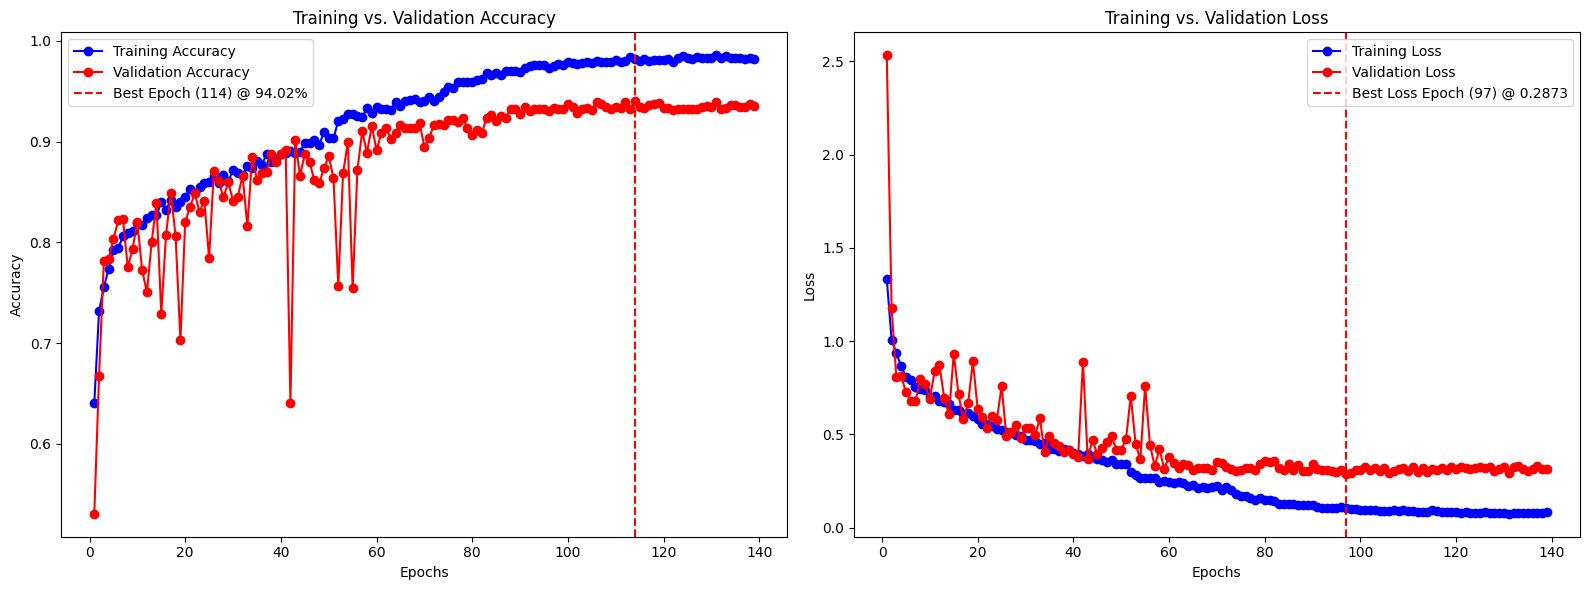

In [ ]:
# ============================================================================
# TAHAP 10: VISUALISASI HASIL TRAINING
# ============================================================================
print("\n" + "="*80)
print("TAHAP 10: VISUALISASI HASIL TRAINING")
print("="*80)

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_ran = range(1, len(acc) + 1)

plt.figure(figsize=(16, 6))
# --- Plot Akurasi ---
plt.subplot(1, 2, 1)
plt.plot(epochs_ran, acc, 'bo-', label='Training Accuracy')
plt.plot(epochs_ran, val_acc, 'ro-', label='Validation Accuracy')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
best_epoch = val_acc.index(max(val_acc)) + 1
plt.axvline(best_epoch, linestyle='--', color='r', label=f'Best Epoch ({best_epoch}) @ {max(val_acc)*100:.2f}%')
plt.legend()

# --- Plot Loss ---
plt.subplot(1, 2, 2)
plt.plot(epochs_ran, loss, 'bo-', label='Training Loss')
plt.plot(epochs_ran, val_loss, 'ro-', label='Validation Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
best_loss_epoch = val_loss.index(min(val_loss)) + 1
plt.axvline(best_loss_epoch, linestyle='--', color='r', label=f'Best Loss Epoch ({best_loss_epoch}) @ {min(val_loss):.4f}')
plt.legend()
plt.tight_layout()
plt.show()

Grafiknya menunjukkan:

- Akurasi: Akurasi training dan validasi naik bersamaan

- Loss: Loss training dan validasi turun bersamaan. Grafik ini mengonfirmasi training berjalan sehat dan tidak overfitting parah.


TAHAP 11: EVALUASI AKHIR PADA TEST SET
Memuat model terbaik dari: /kaggle/working/best_mineral_model_v5.keras...
Model berhasil dimuat.

Mengevaluasi akurasi pada Test Set...
57/57 ━━━━━━━━━━━━━━━━━━━━ 43s 329ms/step - accuracy: 0.9346 - loss: 0.2753

Hasil Evaluasi Test Set:
  Test Accuracy: 92.64%
  Test Loss:     0.3204

Mengumpulkan prediksi untuk Confusion Matrix...

Classification Report:
              precision    recall  f1-score   support

     azurite       0.95      0.97      0.96       174
     calcite       0.95      0.96      0.95       988
      copper       0.84      0.81      0.82       211
    hematite       0.80      0.78      0.79       183
   malachite       0.95      0.95      0.95       252

    accuracy                           0.92      1808
   macro avg       0.90      0.89      0.90      1808
weighted avg       0.92      0.92      0.92      1808


Plotting Confusion Matrix...


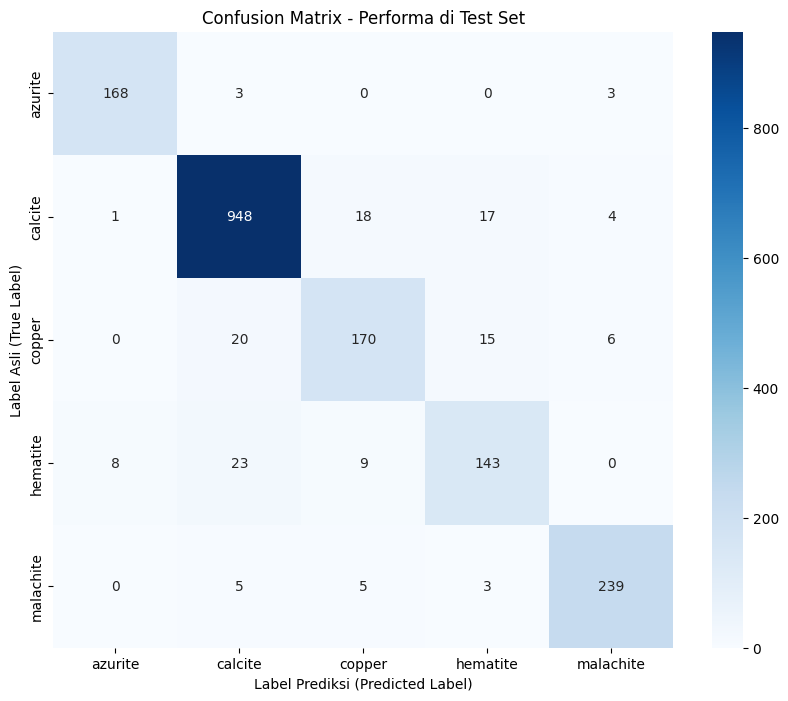

In [ ]:
# ============================================================================
# TAHAP 11: EVALUASI AKHIR
# ============================================================================
print("\n" + "="*80)
print("TAHAP 11: EVALUASI AKHIR PADA TEST SET")
print("="*80)

print(f"Memuat model terbaik dari: {MODEL_SAVE_PATH}...")
best_model = models.load_model(MODEL_SAVE_PATH)
print("Model berhasil dimuat.")

print("\nMengevaluasi akurasi pada Test Set...")
test_loss, test_accuracy = best_model.evaluate(test_dataset, steps=test_size, verbose=1)
print(f"\nHasil Evaluasi Test Set:")
print(f"  Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"  Test Loss:     {test_loss:.4f}")

print("\nMengumpulkan prediksi untuk Confusion Matrix...")
all_true_labels = []
all_pred_labels = []
for images, labels in test_dataset:
    all_true_labels.extend(labels.numpy())
    preds = best_model.predict(images, verbose=0)
    all_pred_labels.extend(np.argmax(preds, axis=1))

print("\nClassification Report:")
print(classification_report(all_true_labels, all_pred_labels, target_names=class_names))

print("\nPlotting Confusion Matrix...")
cm = confusion_matrix(all_true_labels, all_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Performa di Test Set')
plt.ylabel('Label Asli (True Label)')
plt.xlabel('Label Prediksi (Predicted Label)')
plt.show()

Ini adalah "Ujian Akhir". Mengambil model terbaik (dari Epoch 114) dan mengujinya pakai test_dataset (data yang belum pernah dilihat sama sekali).

- Hasil Akhir: Model mendapat akurasi 92.64% di data tes. Ini hasil yang sangat solid.

- Classification Report & Confusion Matrix: Menunjukkan rincian performa. Model sangat jago di azurite dan calcite (95-96%), tapi kadang masih agak bingung membedakan copper dan hematite.

Model /kaggle/working/best_mineral_model_v5.keras berhasil di-load.

--- Hasil Prediksi (Semua Kemungkinan) ---
Gambar: /kaggle/input/azurite/Azurite_test.jpg
  - azurite   : 100.00%
  - malachite : 0.00%
  - hematite  : 0.00%
  - copper    : 0.00%
  - calcite   : 0.00%


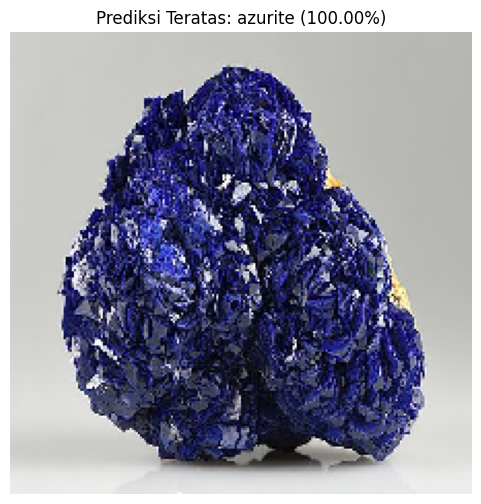

In [ ]:
# ===========================================================================
# TAHAP 12: PREDIKSI GAMBAR BARU (LIHAT SEMUA KEMUNGKINAN)
# ===========================================================================
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Daftar nama kelas
class_names = ['azurite', 'calcite', 'copper', 'hematite', 'malachite']

# 2. Load model terbaik yang sudah disimpan
model_path = '/kaggle/working/best_mineral_model_v5.keras'
if not os.path.exists(model_path):
    print(f"[ERROR] Model tidak ditemukan di {model_path}")
    print("Pastikan TAHAP 9 sudah selesai dan file model sudah tersimpan.")
else:
    best_model = load_model(model_path)
    print(f"Model {model_path} berhasil di-load.")

    # 3. Tentukan path gambar Anda
    path_gambar_saya = '/kaggle/input/azurite/Azurite_test.jpg'

    try:
        # 4. Load dan Pre-process gambar
        img = image.load_img(
            path_gambar_saya,
            target_size=(224, 224) # Sesuaikan dengan IMG_SIZE Anda
        )

        # Ubah gambar ke array
        img_array = image.img_to_array(img)

        # Normalisasi (SANGAT PENTING, harus sama dengan TAHAP 6)
        img_array = img_array / 255.0

        # Tambahkan dimensi batch (model butuh input (1, 224, 224, 3))
        img_batch = np.expand_dims(img_array, axis=0)

        # 5. Lakukan prediksi
        predictions = best_model.predict(img_batch, verbose=0)
        scores = predictions[0] # Ambil array probabilitasnya

        # 6. Pasangkan kelas dengan skornya
        all_predictions = []
        for i in range(len(class_names)):
            all_predictions.append((class_names[i], scores[i] * 100))

        # Urutkan berdasarkan skor (confidence) dari tertinggi ke terendah
        all_predictions.sort(key=lambda x: x[1], reverse=True)

        # 7. Dapatkan hasil terbaik (untuk judul plot)
        top_class = all_predictions[0][0]
        top_confidence = all_predictions[0][1]

        # 8. Tampilkan semua hasil
        print(f"\n--- Hasil Prediksi (Semua Kemungkinan) ---")
        print(f"Gambar: {path_gambar_saya}")

        for (kelas, confidence) in all_predictions:
            print(f"  - {kelas.ljust(10)}: {confidence:.2f}%") # ljust untuk merapikan

        # 9. Tampilkan gambar dengan prediksi teratas
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(f"Prediksi Teratas: {top_class} ({top_confidence:.2f}%)")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"\n[ERROR] File tidak ditemukan di: {path_gambar_saya}")
        print("Pastikan Anda sudah mengganti 'MASUKKAN_PATH_GAMBAR_ANDA_DI_SINI.jpg' dengan path yang benar.")
    except Exception as e:
        print(f"Gagal memproses gambar: {e}")

Ini adalah demo cara memakai model yang sudah jadi.

- Gambar 1 (Azurite_test.jpg): Model sangat yakin (100%) bahwa ini azurite.


Model /kaggle/working/best_mineral_model_v5.keras berhasil di-load.

--- Hasil Prediksi (Semua Kemungkinan) ---
Gambar: /kaggle/input/campur/c.jpg
  - calcite   : 99.99%
  - copper    : 0.00%
  - malachite : 0.00%
  - hematite  : 0.00%
  - azurite   : 0.00%


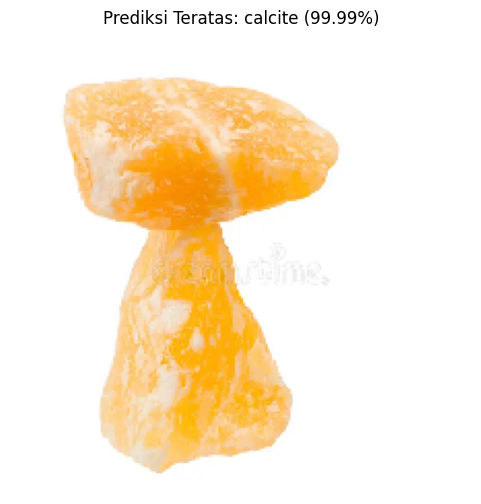

In [ ]:
# ===========================================================================
# TAHAP 12: PREDIKSI GAMBAR BARU (LIHAT SEMUA KEMUNGKINAN)
# ===========================================================================
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Daftar nama kelas (Disamakan dengan output TAHAP 4)
class_names = ['azurite', 'calcite', 'copper', 'hematite', 'malachite']

# 2. Load model terbaik yang sudah disimpan
model_path = '/kaggle/working/best_mineral_model_v5.keras'
if not os.path.exists(model_path):
    print(f"[ERROR] Model tidak ditemukan di {model_path}")
    print("Pastikan TAHAP 9 sudah selesai dan file model sudah tersimpan.")
else:
    best_model = load_model(model_path)
    print(f"Model {model_path} berhasil di-load.")

    # 3. Tentukan path gambar Anda
    path_gambar_saya = '/kaggle/input/campur/c.jpg'

    try:
        # 4. Load dan Pre-process gambar
        img = image.load_img(
            path_gambar_saya,
            target_size=(224, 224) # Sesuaikan dengan IMG_SIZE Anda
        )

        # Ubah gambar ke array
        img_array = image.img_to_array(img)

        # Normalisasi (SANGAT PENTING, harus sama dengan TAHAP 6)
        img_array = img_array / 255.0

        # Tambahkan dimensi batch (model butuh input (1, 224, 224, 3))
        img_batch = np.expand_dims(img_array, axis=0)

        # 5. Lakukan prediksi
        predictions = best_model.predict(img_batch, verbose=0)
        scores = predictions[0] # Ambil array probabilitasnya

        # 6. Pasangkan kelas dengan skornya
        all_predictions = []
        for i in range(len(class_names)):
            all_predictions.append((class_names[i], scores[i] * 100))

        # Urutkan berdasarkan skor (confidence) dari tertinggi ke terendah
        all_predictions.sort(key=lambda x: x[1], reverse=True)

        # 7. Dapatkan hasil terbaik (untuk judul plot)
        top_class = all_predictions[0][0]
        top_confidence = all_predictions[0][1]

        # 8. Tampilkan semua hasil
        print(f"\n--- Hasil Prediksi (Semua Kemungkinan) ---")
        print(f"Gambar: {path_gambar_saya}")

        for (kelas, confidence) in all_predictions:
            print(f"  - {kelas.ljust(10)}: {confidence:.2f}%") # ljust untuk merapikan

        # 9. Tampilkan gambar dengan prediksi teratas
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(f"Prediksi Teratas: {top_class} ({top_confidence:.2f}%)")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"\n[ERROR] File tidak ditemukan di: {path_gambar_saya}")
        print("Pastikan Anda sudah mengganti 'MASUKKAN_PATH_GAMBAR_ANDA_DI_SINI.jpg' dengan path yang benar.")
    except Exception as e:
        print(f"Gagal memproses gambar: {e}")

Model /kaggle/working/best_mineral_model_v5.keras berhasil di-load.

--- Hasil Prediksi (Semua Kemungkinan) ---
Gambar: /kaggle/input/campur/copper.jpg
  - copper    : 88.96%
  - calcite   : 6.21%
  - hematite  : 4.83%
  - azurite   : 0.00%
  - malachite : 0.00%


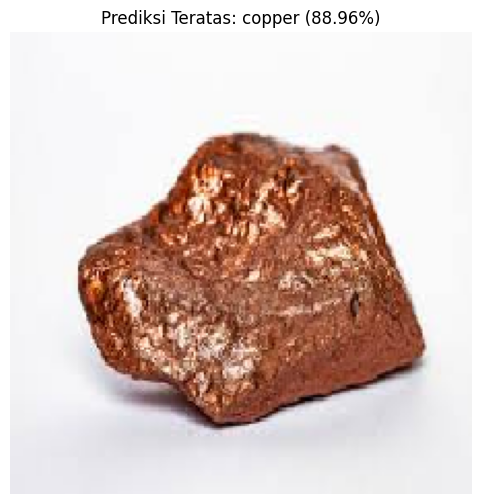

In [ ]:
# ===========================================================================
# TAHAP 12: PREDIKSI GAMBAR BARU (LIHAT SEMUA KEMUNGKINAN)
# ===========================================================================
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Daftar nama kelas (Disamakan dengan output TAHAP 4)
class_names = ['azurite', 'calcite', 'copper', 'hematite', 'malachite']

# 2. Load model terbaik yang sudah disimpan
model_path = '/kaggle/working/best_mineral_model_v5.keras'
if not os.path.exists(model_path):
    print(f"[ERROR] Model tidak ditemukan di {model_path}")
    print("Pastikan TAHAP 9 sudah selesai dan file model sudah tersimpan.")
else:
    best_model = load_model(model_path)
    print(f"Model {model_path} berhasil di-load.")

    # 3. Tentukan path gambar Anda
    path_gambar_saya = '/kaggle/input/campur/copper.jpg'

    try:
        # 4. Load dan Pre-process gambar
        img = image.load_img(
            path_gambar_saya,
            target_size=(224, 224) # Sesuaikan dengan IMG_SIZE Anda
        )

        # Ubah gambar ke array
        img_array = image.img_to_array(img)

        # Normalisasi (SANGAT PENTING, harus sama dengan TAHAP 6)
        img_array = img_array / 255.0

        # Tambahkan dimensi batch (model butuh input (1, 224, 224, 3))
        img_batch = np.expand_dims(img_array, axis=0)

        # 5. Lakukan prediksi
        predictions = best_model.predict(img_batch, verbose=0)
        scores = predictions[0] # Ambil array probabilitasnya

        # 6. Pasangkan kelas dengan skornya
        all_predictions = []
        for i in range(len(class_names)):
            all_predictions.append((class_names[i], scores[i] * 100))

        # Urutkan berdasarkan skor (confidence) dari tertinggi ke terendah
        all_predictions.sort(key=lambda x: x[1], reverse=True)

        # 7. Dapatkan hasil terbaik (untuk judul plot)
        top_class = all_predictions[0][0]
        top_confidence = all_predictions[0][1]

        # 8. Tampilkan semua hasil
        print(f"\n--- Hasil Prediksi (Semua Kemungkinan) ---")
        print(f"Gambar: {path_gambar_saya}")

        for (kelas, confidence) in all_predictions:
            print(f"  - {kelas.ljust(10)}: {confidence:.2f}%") # ljust untuk merapikan

        # 9. Tampilkan gambar dengan prediksi teratas
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(f"Prediksi Teratas: {top_class} ({top_confidence:.2f}%)")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"\n[ERROR] File tidak ditemukan di: {path_gambar_saya}")
        print("Pastikan Anda sudah mengganti 'MASUKKAN_PATH_GAMBAR_ANDA_DI_SINI.jpg' dengan path yang benar.")
    except Exception as e:
        print(f"Gagal memproses gambar: {e}")

Model /kaggle/working/best_mineral_model_v5.keras berhasil di-load.

--- Hasil Prediksi (Semua Kemungkinan) ---
Gambar: /kaggle/input/campur/malachite.jpg
  - malachite : 99.99%
  - copper    : 0.01%
  - azurite   : 0.00%
  - calcite   : 0.00%
  - hematite  : 0.00%


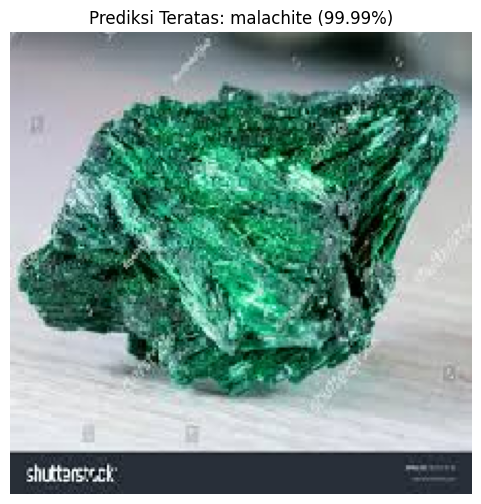

In [ ]:
# ===========================================================================
# TAHAP 12: PREDIKSI GAMBAR BARU (LIHAT SEMUA KEMUNGKINAN)
# ===========================================================================
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Daftar nama kelas (Disamakan dengan output TAHAP 4)
class_names = ['azurite', 'calcite', 'copper', 'hematite', 'malachite']

# 2. Load model terbaik yang sudah disimpan
model_path = '/kaggle/working/best_mineral_model_v5.keras' #
if not os.path.exists(model_path):
    print(f"[ERROR] Model tidak ditemukan di {model_path}")
    print("Pastikan TAHAP 9 sudah selesai dan file model sudah tersimpan.")
else:
    best_model = load_model(model_path)
    print(f"Model {model_path} berhasil di-load.")

    # 3. Tentukan path gambar Anda
    path_gambar_saya = '/kaggle/input/campur/malachite.jpg'

    try:
        # 4. Load dan Pre-process gambar
        img = image.load_img(
            path_gambar_saya,
            target_size=(224, 224) # Sesuaikan dengan IMG_SIZE Anda
        )

        # Ubah gambar ke array
        img_array = image.img_to_array(img)

        # Normalisasi (SANGAT PENTING, harus sama dengan TAHAP 6)
        img_array = img_array / 255.0

        # Tambahkan dimensi batch (model butuh input (1, 224, 224, 3))
        img_batch = np.expand_dims(img_array, axis=0)

        # 5. Lakukan prediksi
        predictions = best_model.predict(img_batch, verbose=0)
        scores = predictions[0] # Ambil array probabilitasnya

        # 6. Pasangkan kelas dengan skornya
        all_predictions = []
        for i in range(len(class_names)):
            all_predictions.append((class_names[i], scores[i] * 100))

        # Urutkan berdasarkan skor (confidence) dari tertinggi ke terendah
        all_predictions.sort(key=lambda x: x[1], reverse=True)

        # 7. Dapatkan hasil terbaik (untuk judul plot)
        top_class = all_predictions[0][0]
        top_confidence = all_predictions[0][1]

        # 8. Tampilkan semua hasil
        print(f"\n--- Hasil Prediksi (Semua Kemungkinan) ---")
        print(f"Gambar: {path_gambar_saya}")

        for (kelas, confidence) in all_predictions:
            print(f"  - {kelas.ljust(10)}: {confidence:.2f}%") # ljust untuk merapikan

        # 9. Tampilkan gambar dengan prediksi teratas
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(f"Prediksi Teratas: {top_class} ({top_confidence:.2f}%)")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"\n[ERROR] File tidak ditemukan di: {path_gambar_saya}")
        print("Pastikan Anda sudah mengganti 'MASUKKAN_PATH_GAMBAR_ANDA_DI_SINI.jpg' dengan path yang benar.")
    except Exception as e:
        print(f"Gagal memproses gambar: {e}")

Model /kaggle/working/best_mineral_model_v5.keras berhasil di-load.

--- Hasil Prediksi (Semua Kemungkinan) ---
Gambar: /kaggle/input/hematitejuga/hematite2.jpg
  - hematite  : 80.06%
  - calcite   : 19.90%
  - copper    : 0.04%
  - malachite : 0.00%
  - azurite   : 0.00%


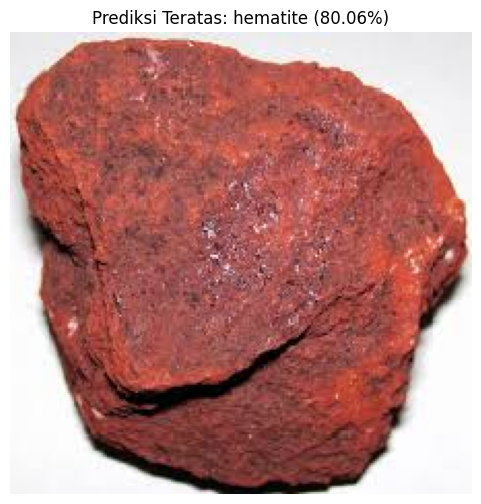

In [ ]:
# ===========================================================================
# TAHAP 12: PREDIKSI GAMBAR BARU (LIHAT SEMUA KEMUNGKINAN)
# ===========================================================================
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os

# 1. Daftar nama kelas (Disamakan dengan output TAHAP 4)
class_names = ['azurite', 'calcite', 'copper', 'hematite', 'malachite']

# 2. Load model terbaik yang sudah disimpan
model_path = '/kaggle/working/best_mineral_model_v5.keras'
if not os.path.exists(model_path):
    print(f"[ERROR] Model tidak ditemukan di {model_path}")
    print("Pastikan TAHAP 9 sudah selesai dan file model sudah tersimpan.")
else:
    best_model = load_model(model_path)
    print(f"Model {model_path} berhasil di-load.")

    # 3. Tentukan path gambar Anda
    path_gambar_saya = '/kaggle/input/hematitejuga/hematite2.jpg'

    try:
        # 4. Load dan Pre-process gambar
        img = image.load_img(
            path_gambar_saya,
            target_size=(224, 224) # Sesuaikan dengan IMG_SIZE Anda
        )

        # Ubah gambar ke array
        img_array = image.img_to_array(img)

        # Normalisasi (SANGAT PENTING, harus sama dengan TAHAP 6)
        img_array = img_array / 255.0

        # Tambahkan dimensi batch (model butuh input (1, 224, 224, 3))
        img_batch = np.expand_dims(img_array, axis=0)

        # 5. Lakukan prediksi
        predictions = best_model.predict(img_batch, verbose=0)
        scores = predictions[0] # Ambil array probabilitasnya

        # 6. Pasangkan kelas dengan skornya
        all_predictions = []
        for i in range(len(class_names)):
            all_predictions.append((class_names[i], scores[i] * 100))

        # Urutkan berdasarkan skor (confidence) dari tertinggi ke terendah
        all_predictions.sort(key=lambda x: x[1], reverse=True)

        # 7. Dapatkan hasil terbaik (untuk judul plot)
        top_class = all_predictions[0][0]
        top_confidence = all_predictions[0][1]

        # 8. Tampilkan semua hasil
        print(f"\n--- Hasil Prediksi (Semua Kemungkinan) ---")
        print(f"Gambar: {path_gambar_saya}")

        for (kelas, confidence) in all_predictions:
            print(f"  - {kelas.ljust(10)}: {confidence:.2f}%") # ljust untuk merapikan

        # 9. Tampilkan gambar dengan prediksi teratas
        plt.figure(figsize=(6,6))
        plt.imshow(img)
        plt.title(f"Prediksi Teratas: {top_class} ({top_confidence:.2f}%)")
        plt.axis('off')
        plt.show()

    except FileNotFoundError:
        print(f"\n[ERROR] File tidak ditemukan di: {path_gambar_saya}")
        print("Pastikan Anda sudah mengganti 'MASUKKAN_PATH_GAMBAR_ANDA_DI_SINI.jpg' dengan path yang benar.")
    except Exception as e:
        print(f"Gagal memproses gambar: {e}")

In [ ]:
# ===========================================================================
# TAHAP 13: CEK FILE OUTPUT DENGAN KODE
# ===========================================================================
!ls -l /kaggle/working/

total 69048
-rw-r--r-- 1 root root 70699463 Nov  9 14:54 best_mineral_model_v5.keras
drwxr-xr-x 7 root root     4096 Nov  9 10:19 mineral_selected_v5
